# Automatic Detection of Stuttering Events in Natural Speech Using Deep Learning and MFCC-Based Acoustic Modeling

In [1]:
!git clone https://github.com/apple/ml-stuttering-events-dataset.git
%cd ml-stuttering-events-dataset

Cloning into 'ml-stuttering-events-dataset'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 29 (delta 8), reused 8 (delta 8), pack-reused 12 (from 1)
Receiving objects: 100% (29/29), 465.21 KiB | 2.54 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/kaggle/working/ml-stuttering-events-dataset


In [2]:
!pip install pandas numpy librosa soundfile tqdm requests pydub

In [3]:
!pip install pydub

In [4]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import warnings
from tqdm import tqdm
import random
import scipy.io.wavfile as wavfile
from matplotlib.patches import Rectangle
import pathlib
import traceback
import IPython.display as ipd
import soundfile as sf
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
import time

In [ ]:

warnings.filterwarnings("ignore")


os.makedirs('./raw_audio', exist_ok=True)
os.makedirs('./clips', exist_ok=True)
os.makedirs('./features', exist_ok=True)
os.makedirs('./plots', exist_ok=True)


In [ ]:
# 1. Load and process the CSV files 
print("Loading dataset files...")

episodes_df = pd.read_csv('SEP-28k_episodes.csv', header=None)
episodes_df.columns = ['Show', 'EpId', 'URL', 'Source', 'SourceId']

for col in episodes_df.columns:
    if episodes_df[col].dtype == 'object':
        episodes_df[col] = episodes_df[col].str.strip()

labels_df = pd.read_csv('SEP-28k_labels.csv')

print(f"Loaded {len(episodes_df)} episodes and {len(labels_df)} labeled clips")
print("\nEpisodes DataFrame (first 3 rows):")
print(episodes_df.head(3))
print("\nLabels DataFrame (first 3 rows):")
print(labels_df.head(3))

# 2. Create a mapping between episode files and label identifiers
def create_episode_mapping(episodes_df, labels_df):
    """Create mapping between episodes and their standardized identifiers in labels"""
    mapping = {}

    label_shows = labels_df['Show'].unique()

    for _, row in episodes_df.iterrows():
        show_name = row['Show']
        ep_id = row['EpId']

        if 'Source' in row and row['Source'] in label_shows:
            mapping[(show_name, ep_id)] = (row['Source'], row['SourceId'])

        elif show_name in label_shows:
            mapping[(show_name, ep_id)] = (show_name, ep_id)
    
        else:
            mapping[(show_name, ep_id)] = ("HeStutters", ep_id)

    return mapping




episode_mapping = create_episode_mapping(episodes_df, labels_df)
print(f"\nCreated mapping for {len(episode_mapping)} episodes")

# 3. Function to download audio files without using the problematic script
def download_audio_files(episodes_df, n=2, output_dir='./raw_audio'):
    """Download audio files for a sample of episodes directly in Python"""
    os.makedirs(output_dir, exist_ok=True)

    sample_episodes = episodes_df.head(n)

    downloaded_info = []

    for _, episode in tqdm(sample_episodes.iterrows(),
                          total=len(sample_episodes),
                          desc="Downloading episodes"):

        show_dir = os.path.join(output_dir, episode['Source'])
        os.makedirs(show_dir, exist_ok=True)

        ep_id = str(episode['SourceId'])
        output_path = os.path.join(show_dir, f"{ep_id}.mp3")

        if os.path.exists(output_path):
            print(f"File already exists: {output_path}")
            downloaded_info.append({
                'file_path': output_path,
                'show': episode['Show'],
                'ep_id': episode['EpId']
            })
            continue

        try:
            url = episode['URL']
            print(f"Downloading {url} to {output_path}")

            response = requests.get(url, stream=True)
            response.raise_for_status()

            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            print(f"Successfully downloaded {output_path}")
            downloaded_info.append({
                'file_path': output_path,
                'show': episode['Show'],
                'ep_id': episode['EpId']
            })

        except Exception as e:
            print(f"Error downloading {url}: {str(e)}")

    return downloaded_info


# 4. Download sample episodes
num_episodes = len(episodes_df)
downloaded_info = download_audio_files(episodes_df, n=num_episodes)
print(f"\nDownloaded {len(downloaded_info)} audio files")

# 5. Extract clips with robust error handling
def extract_clips(labels_file, output_dir='./clips', data_dir = './raw_audio'):
    data = pd.read_csv(labels_file, dtype={"EpId":str})

    shows = data.Show
    episodes = data.EpId
    clip_idxs = data.ClipId
    starts = data.Start
    stops = data.Stop
    labels = data.iloc[:,5:].values

    n_items = len(shows)

    loaded_wav = ""
    cur_iter = range(n_items)

    for i in tqdm(cur_iter):
      clip_idx = clip_idxs[i]
      show_abrev = shows[i]
      episode = episodes[i].strip()

      
      wav_path = f"{data_dir}/{shows[i]}/{episode}.mp3"
      clip_dir = pathlib.Path(f"{output_dir}/{show_abrev}/{episode}/")
      clip_path = f"{clip_dir}/{shows[i]}_{episode}_{clip_idx}.wav"

      if not os.path.exists(wav_path):
        continue

      
      os.makedirs(clip_dir, exist_ok=True)

   
      if wav_path != loaded_wav:
        audio, sample_rate = librosa.load(wav_path, sr=16000)
        assert sample_rate == 16000, "Sample rate must be 16 khz"

        
        loaded_wav = wav_path

      
      clip = audio[starts[i]:stops[i]]
      wavfile.write(clip_path, sample_rate, clip)



# 6. Extract clips using the robust function
extract_clips('SEP-28k_labels.csv')

# 7. Plot audio waveform and spectrogram functions
def plot_audio_waveform(audio_path, title=None):
    """Plot the waveform of an audio file"""
    y, sr = librosa.load(audio_path, sr=16000)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title or os.path.basename(audio_path))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def plot_audio_spectrogram(audio_path, title=None):
    """Plot the mel spectrogram of an audio file"""
    y, sr = librosa.load(audio_path, sr=16000)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title or f"Mel Spectrogram - {os.path.basename(audio_path)}")
    plt.tight_layout()
    plt.show()

# 8. Function to analyze a clip
def analyze_clip(clip, labels_df=None):
    """Analyze and display information about a clip"""
    audio_path = clip['path']
    clip_id = clip['clip_id']
    show = clip['show']
    ep_id = clip['ep_id']
    row = clip['row']

    
    stutter_types = []
    for field in ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']:
        if field in row and row[field] > 0:
            stutter_types.append(field)

    stutter_label = ", ".join(stutter_types) if stutter_types else "No stuttering"

    
    print(f"Clip ID: {clip_id}")
    print(f"Show: {show}, Episode: {ep_id}")
    print(f"Stutter Label: {stutter_label}")
    if 'Start' in row and 'Stop' in row:
        print(f"Start Sample: {row['Start']}")
        print(f"Stop Sample: {row['Stop']}")
        print(f"Duration: {(row['Stop'] - row['Start'])/16000:.2f}s")

    
    plot_audio_waveform(audio_path, title=f"Waveform - {stutter_label}")
    plot_audio_spectrogram(audio_path, title=f"Spectrogram - {stutter_label}")


Loading dataset files...
Loaded 385 episodes and 28177 labeled clips

Episodes DataFrame (first 3 rows):
                                                Show  \
0  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   
1  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   
2  He_Stutters_Podcast_–_Make_Room_For_The_Stutte...   

                        EpId  \
0  episode-208-with-kelsey-h   
1  episode-208-with-kelsey-h   
2  episode-208-with-kelsey-h   

                                                 URL      Source  SourceId  
0  https://stutterrockstar.files.wordpress.com/20...  HeStutters         0  
1  https://stutterrockstar.files.wordpress.com/20...  HeStutters         1  
2  https://stutterrockstar.files.wordpress.com/20...  HeStutters         2  

Labels DataFrame (first 3 rows):
         Show  EpId  ClipId     Start      Stop  Unsure  PoorAudioQuality  \
0  HeStutters     0       0  31900320  31948320       0                 0   
1  HeStutters     0       1  31977120  320251

Successfully downloaded ./raw_audio/HeStutters/0.mp3


Successfully downloaded ./raw_audio/HeStutters/1.mp3


Successfully downloaded ./raw_audio/HeStutters/2.mp3


Successfully downloaded ./raw_audio/HeStutters/3.mp3


Successfully downloaded ./raw_audio/HeStutters/4.mp3


Successfully downloaded ./raw_audio/HeStutters/5.mp3


Successfully downloaded ./raw_audio/HeStutters/6.mp3


Successfully downloaded ./raw_audio/HeStutters/7.mp3


Successfully downloaded ./raw_audio/HeStutters/8.mp3


Successfully downloaded ./raw_audio/HeStutters/9.mp3


Successfully downloaded ./raw_audio/HeStutters/10.mp3


Successfully downloaded ./raw_audio/HeStutters/11.mp3


Successfully downloaded ./raw_audio/HeStutters/12.mp3


Successfully downloaded ./raw_audio/HeStutters/13.mp3


Successfully downloaded ./raw_audio/HeStutters/14.mp3


Successfully downloaded ./raw_audio/HeStutters/15.mp3


Successfully downloaded ./raw_audio/HeStutters/16.mp3


Successfully downloaded ./raw_audio/HeStutters/17.mp3


Successfully downloaded ./raw_audio/HeStutters/18.mp3


Successfully downloaded ./raw_audio/HeStutters/19.mp3


Successfully downloaded ./raw_audio/HeStutters/20.mp3


Successfully downloaded ./raw_audio/HeStutters/21.mp3


Successfully downloaded ./raw_audio/HeStutters/22.mp3


Successfully downloaded ./raw_audio/HeStutters/23.mp3


Successfully downloaded ./raw_audio/HVSA/0.mp3


Successfully downloaded ./raw_audio/HVSA/1.mp3


Successfully downloaded ./raw_audio/HVSA/2.mp3


Successfully downloaded ./raw_audio/HVSA/3.mp3


Error downloading http://istuttersowhat.com/podcast/ISSW007final.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSW007final.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast001.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast001.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast003-MikeLapot.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast003-MikeLapot.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast004-the-walk.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast004-the-walk.mp3


Error downloading http://istuttersowhat.com/podcast/ISSWPodcast005.mp3: 404 Client Error: Not Found for url: http://istuttersowhat.com/podcast/ISSWPodcast005.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/0.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/1.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/2.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/3.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/4.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/5.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/6.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/7.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/8.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/9.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/10.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/11.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/12.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/13.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/14.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/15.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/16.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/17.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/18.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/19.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/20.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/21.mp3


Error downloading https://traffic.libsyn.com/secure/mystutteringlife/Roy-Johnson-ef1c45683c008.m4a?dest-id=1660175: 404 Client Error: Not Found for url: https://traffic.libsyn.com/secure/mystutteringlife/Roy-Johnson-ef1c45683c008.m4a?dest-id=1660175


Successfully downloaded ./raw_audio/MyStutteringLife/23.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/24.mp3


Error downloading https://traffic.libsyn.com/secure/mystutteringlife/Stuttering---Dating-a7bc436740b51.m4a?dest-id=1660175: 404 Client Error: Not Found for url: https://traffic.libsyn.com/secure/mystutteringlife/Stuttering---Dating-a7bc436740b51.m4a?dest-id=1660175


Successfully downloaded ./raw_audio/MyStutteringLife/26.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/27.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/28.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/29.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/30.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/31.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/32.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/33.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/34.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/35.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/36.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/37.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/38.mp3


Successfully downloaded ./raw_audio/MyStutteringLife/39.mp3


Error downloading http://feeds.soundcloud.com/stream/393268140-user-709642316-episode-1-pilot.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/393268140-user-709642316-episode-1-pilot.mp3


Error downloading http://feeds.soundcloud.com/stream/407179179-user-709642316-episode-3-dont-let-anything-get-in-the-way-with-denis-wright.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/407179179-user-709642316-episode-3-dont-let-anything-get-in-the-way-with-denis-wright.mp3


Error downloading http://feeds.soundcloud.com/stream/413976822-user-709642316-episode-4-totally-transformed-with-monica-shanahan.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/413976822-user-709642316-episode-4-totally-transformed-with-monica-shanahan.mp3


Error downloading http://feeds.soundcloud.com/stream/420675876-user-709642316-bonus-episode-1-stuttering-research-with-tatiana-izmaylova.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/420675876-user-709642316-bonus-episode-1-stuttering-research-with-tatiana-izmaylova.mp3


Error downloading http://feeds.soundcloud.com/stream/421724238-user-709642316-svpodcast-ep-5.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/421724238-user-709642316-svpodcast-ep-5.mp3


Error downloading http://feeds.soundcloud.com/stream/428515275-user-709642316-episode-6-the-martial-art-of-speaking-with-kate-salkeld.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/428515275-user-709642316-episode-6-the-martial-art-of-speaking-with-kate-salkeld.mp3


Error downloading http://feeds.soundcloud.com/stream/435397359-user-709642316-episode-7-with-tom-deblaere.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/435397359-user-709642316-episode-7-with-tom-deblaere.mp3


Error downloading http://feeds.soundcloud.com/stream/442534920-user-709642316-episode-8-self-acceptance-and-eloquence-with-noel-kumar.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/442534920-user-709642316-episode-8-self-acceptance-and-eloquence-with-noel-kumar.mp3


Error downloading http://feeds.soundcloud.com/stream/451194234-user-709642316-episode-9-then-versus-now-with-kristy-warden.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/451194234-user-709642316-episode-9-then-versus-now-with-kristy-warden.mp3


Error downloading http://feeds.soundcloud.com/stream/462134433-user-709642316-episode-11-it-all-adds-up-with-strong-technique-with-marcel-conway.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/462134433-user-709642316-episode-11-it-all-adds-up-with-strong-technique-with-marcel-conway.mp3


Error downloading http://feeds.soundcloud.com/stream/468076068-user-709642316-episode-12-success-with-many-voices-with-yasmeen-hassan.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/468076068-user-709642316-episode-12-success-with-many-voices-with-yasmeen-hassan.mp3


Error downloading http://feeds.soundcloud.com/stream/481363221-user-709642316-episode-13-stay-chilled-and-enjoy-speaking-with-phil-jeffrey.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/481363221-user-709642316-episode-13-stay-chilled-and-enjoy-speaking-with-phil-jeffrey.mp3


Error downloading http://feeds.soundcloud.com/stream/494066280-user-709642316-episode-15-accessibility-and-the-future-with-ross-mullen.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/494066280-user-709642316-episode-15-accessibility-and-the-future-with-ross-mullen.mp3


Error downloading http://feeds.soundcloud.com/stream/500204031-user-709642316-episode-16-the-best-of-me-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/500204031-user-709642316-episode-16-the-best-of-me-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/506871492-user-709642316-episode-17-the-hexagon-and-its-application-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/506871492-user-709642316-episode-17-the-hexagon-and-its-application-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/514061178-user-709642316-episode-18-a-journey-begun-with-anthony-steed.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/514061178-user-709642316-episode-18-a-journey-begun-with-anthony-steed.mp3


Error downloading http://feeds.soundcloud.com/stream/520973022-user-709642316-episode-19-the-abc-of-everything-with-scott-monson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/520973022-user-709642316-episode-19-the-abc-of-everything-with-scott-monson.mp3


Error downloading http://feeds.soundcloud.com/stream/528397401-user-709642316-episode-20-goals-achieved-more-to-explore-with-freddie-westhuizen.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/528397401-user-709642316-episode-20-goals-achieved-more-to-explore-with-freddie-westhuizen.mp3


Error downloading http://feeds.soundcloud.com/stream/547557738-user-709642316-episode-24-2018-in-review-with-your-hosts.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/547557738-user-709642316-episode-24-2018-in-review-with-your-hosts.mp3


Error downloading http://feeds.soundcloud.com/stream/569330349-user-709642316-episode-25-part-1-with-mike-wilson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/569330349-user-709642316-episode-25-part-1-with-mike-wilson.mp3


Error downloading http://feeds.soundcloud.com/stream/576628695-user-709642316-episode-26-part-2-with-mike-wilson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/576628695-user-709642316-episode-26-part-2-with-mike-wilson.mp3


Error downloading http://feeds.soundcloud.com/stream/591248463-user-709642316-episode-28-part-1-with-ankur-aryaa-and-eugene-barannikov.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/591248463-user-709642316-episode-28-part-1-with-ankur-aryaa-and-eugene-barannikov.mp3


Error downloading http://feeds.soundcloud.com/stream/598593423-user-709642316-episode-29-part-2-with-ankur-aryaa-and-eugene-barannikov.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/598593423-user-709642316-episode-29-part-2-with-ankur-aryaa-and-eugene-barannikov.mp3


Error downloading http://feeds.soundcloud.com/stream/606220788-user-709642316-episode-30-with-todd-wheldon.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/606220788-user-709642316-episode-30-with-todd-wheldon.mp3


Error downloading http://feeds.soundcloud.com/stream/612122499-user-709642316-episode-31-moving-forward-with-katy-johnson.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/612122499-user-709642316-episode-31-moving-forward-with-katy-johnson.mp3


Error downloading http://feeds.soundcloud.com/stream/619339989-user-709642316-episode-32-with-martin-bates.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/619339989-user-709642316-episode-32-with-martin-bates.mp3


Error downloading http://feeds.soundcloud.com/stream/625233042-user-709642316-episode-33-with-jhoney-ekladious.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/625233042-user-709642316-episode-33-with-jhoney-ekladious.mp3


Error downloading http://feeds.soundcloud.com/stream/632551599-user-709642316-episode-34-with-peter-wise.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/632551599-user-709642316-episode-34-with-peter-wise.mp3


Error downloading http://feeds.soundcloud.com/stream/668349341-user-709642316-episode-35-ride-the-wave-with-riley-cadman.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/668349341-user-709642316-episode-35-ride-the-wave-with-riley-cadman.mp3


Error downloading http://feeds.soundcloud.com/stream/710943172-user-709642316-svpodcast-ep37.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/710943172-user-709642316-svpodcast-ep37.mp3


Error downloading http://feeds.soundcloud.com/stream/714010465-user-709642316-episode-38-life-love-and-relationships-part-2-with-alex-cowan-and-kate.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/714010465-user-709642316-episode-38-life-love-and-relationships-part-2-with-alex-cowan-and-kate.mp3


Error downloading http://feeds.soundcloud.com/stream/722540014-user-709642316-episode-40-its-never-to-late-to-be-a-great-speaker-with-virginia-hortis.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/722540014-user-709642316-episode-40-its-never-to-late-to-be-a-great-speaker-with-virginia-hortis.mp3


Error downloading http://feeds.soundcloud.com/stream/728507386-user-709642316-episode-41-destroy-the-fear-with-kenny-macheka.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/728507386-user-709642316-episode-41-destroy-the-fear-with-kenny-macheka.mp3


Error downloading http://feeds.soundcloud.com/stream/730703080-user-709642316-episode-42-there-is-more-to-stuttering-than-stuttering-with-geoff-johnston.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/730703080-user-709642316-episode-42-there-is-more-to-stuttering-than-stuttering-with-geoff-johnston.mp3


Error downloading http://feeds.soundcloud.com/stream/746278345-user-709642316-episode-45-goodby-from-your-hosts.mp3: 404 Client Error: Not Found for url: https://feeds.soundcloud.com/stream/746278345-user-709642316-episode-45-goodby-from-your-hosts.mp3


Successfully downloaded ./raw_audio/StutterTalk/0.mp3


Successfully downloaded ./raw_audio/StutterTalk/1.mp3


Successfully downloaded ./raw_audio/StutterTalk/2.mp3


Successfully downloaded ./raw_audio/StutterTalk/3.mp3


Successfully downloaded ./raw_audio/StutterTalk/4.mp3


Successfully downloaded ./raw_audio/StutterTalk/5.mp3


Successfully downloaded ./raw_audio/StutterTalk/6.mp3


Successfully downloaded ./raw_audio/StutterTalk/7.mp3


Successfully downloaded ./raw_audio/StutterTalk/8.mp3


Successfully downloaded ./raw_audio/StutterTalk/9.mp3


Successfully downloaded ./raw_audio/StutterTalk/10.mp3


Successfully downloaded ./raw_audio/StutterTalk/11.mp3


Successfully downloaded ./raw_audio/StutterTalk/12.mp3


Successfully downloaded ./raw_audio/StutterTalk/13.mp3


Successfully downloaded ./raw_audio/StutterTalk/14.mp3


Successfully downloaded ./raw_audio/StutterTalk/15.mp3


Successfully downloaded ./raw_audio/StutterTalk/16.mp3


Successfully downloaded ./raw_audio/StutterTalk/17.mp3


Successfully downloaded ./raw_audio/StutterTalk/18.mp3


Successfully downloaded ./raw_audio/StutterTalk/19.mp3


Successfully downloaded ./raw_audio/StutterTalk/20.mp3


Successfully downloaded ./raw_audio/StutterTalk/21.mp3


Successfully downloaded ./raw_audio/StutterTalk/22.mp3


Successfully downloaded ./raw_audio/StutterTalk/23.mp3


Successfully downloaded ./raw_audio/StutterTalk/24.mp3


Successfully downloaded ./raw_audio/StutterTalk/25.mp3


Successfully downloaded ./raw_audio/StutterTalk/26.mp3


Successfully downloaded ./raw_audio/StutterTalk/27.mp3


Successfully downloaded ./raw_audio/StutterTalk/28.mp3


Successfully downloaded ./raw_audio/StutterTalk/29.mp3


Successfully downloaded ./raw_audio/StutterTalk/30.mp3


Successfully downloaded ./raw_audio/StutterTalk/31.mp3


Successfully downloaded ./raw_audio/StutterTalk/32.mp3


Successfully downloaded ./raw_audio/StutterTalk/33.mp3


Successfully downloaded ./raw_audio/StutterTalk/34.mp3


Successfully downloaded ./raw_audio/StutterTalk/35.mp3


Successfully downloaded ./raw_audio/StutterTalk/36.mp3


Successfully downloaded ./raw_audio/StutterTalk/37.mp3


Successfully downloaded ./raw_audio/StutterTalk/38.mp3


Successfully downloaded ./raw_audio/StutterTalk/39.mp3


Successfully downloaded ./raw_audio/StutterTalk/40.mp3


Successfully downloaded ./raw_audio/StutterTalk/41.mp3


Successfully downloaded ./raw_audio/StutterTalk/42.mp3


Successfully downloaded ./raw_audio/StutterTalk/43.mp3


Successfully downloaded ./raw_audio/StutterTalk/44.mp3


Successfully downloaded ./raw_audio/StutterTalk/45.mp3


Successfully downloaded ./raw_audio/StutterTalk/46.mp3


Successfully downloaded ./raw_audio/StutterTalk/47.mp3


Successfully downloaded ./raw_audio/StutterTalk/48.mp3


Successfully downloaded ./raw_audio/StutterTalk/49.mp3


Successfully downloaded ./raw_audio/StutterTalk/50.mp3


Successfully downloaded ./raw_audio/StutterTalk/51.mp3


Successfully downloaded ./raw_audio/StutterTalk/52.mp3


Successfully downloaded ./raw_audio/StutterTalk/53.mp3


Successfully downloaded ./raw_audio/StutterTalk/54.mp3


Successfully downloaded ./raw_audio/StutterTalk/55.mp3


Successfully downloaded ./raw_audio/StutterTalk/56.mp3


Successfully downloaded ./raw_audio/StutterTalk/57.mp3


Successfully downloaded ./raw_audio/StutterTalk/58.mp3


Successfully downloaded ./raw_audio/StutterTalk/59.mp3


Successfully downloaded ./raw_audio/StutterTalk/60.mp3


Successfully downloaded ./raw_audio/StutterTalk/61.mp3


Successfully downloaded ./raw_audio/StutterTalk/62.mp3


Successfully downloaded ./raw_audio/StutterTalk/63.mp3


Successfully downloaded ./raw_audio/StutterTalk/64.mp3


Successfully downloaded ./raw_audio/StutterTalk/65.mp3


Successfully downloaded ./raw_audio/StutterTalk/66.mp3


Successfully downloaded ./raw_audio/StutterTalk/67.mp3


Successfully downloaded ./raw_audio/StutterTalk/68.mp3


Successfully downloaded ./raw_audio/StutterTalk/69.mp3


Successfully downloaded ./raw_audio/StutterTalk/70.mp3


Successfully downloaded ./raw_audio/StutterTalk/71.mp3


Successfully downloaded ./raw_audio/StutterTalk/72.mp3


Successfully downloaded ./raw_audio/StutterTalk/73.mp3


Successfully downloaded ./raw_audio/StutterTalk/74.mp3


Successfully downloaded ./raw_audio/StutterTalk/75.mp3


Successfully downloaded ./raw_audio/StutterTalk/76.mp3


Successfully downloaded ./raw_audio/StutterTalk/77.mp3


Successfully downloaded ./raw_audio/StutterTalk/78.mp3


Successfully downloaded ./raw_audio/StutterTalk/79.mp3


Successfully downloaded ./raw_audio/StutterTalk/80.mp3


Successfully downloaded ./raw_audio/StutterTalk/81.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/6ctZYoFLT1o/Stuttering-is-Cool-1st-episode.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/6ctZYoFLT1o/Stuttering-is-Cool-1st-episode.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/cgNC5zjE6J4/cool100.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/cgNC5zjE6J4/cool100.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/LNLU2XfWt8E/cool101.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/LNLU2XfWt8E/cool101.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Qp6UWNvsgIY/cool103.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Qp6UWNvsgIY/cool103.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/tTYb1Z

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/rjR8nbLT8vo/cool115.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/rjR8nbLT8vo/cool115.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gXBXKtRsZAA/cool119.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gXBXKtRsZAA/cool119.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/3CEkMGmAWxo/cool120.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/3CEkMGmAWxo/cool120.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ikhqNWW0ZxY/cool124.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ikhqNWW0ZxY/cool124.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ClmJvu5YB6A/cool126.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/63UHi10te5c/cool127.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/63UHi10te5c/cool127.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/jX1GvdliLTw/cool131.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/jX1GvdliLTw/cool131.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Tv9772x6y-U/cool133.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Tv9772x6y-U/cool133.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/zgwmEjBpX2Q/cool136.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/zgwmEjBpX2Q/cool136.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/9PfLcPdEWdw/cool137.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ywXNNRKkf9Y/cool151.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ywXNNRKkf9Y/cool151.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/8VkJj43Kktc/cool158.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/8VkJj43Kktc/cool158.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/JcWnKjOtuyY/cool159.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/JcWnKjOtuyY/cool159.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gVN2kakZXTs/cool160.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gVN2kakZXTs/cool160.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/6cQtXSy6BEI/cool163.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/1mZVOjJVSHk/cool176.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/1mZVOjJVSHk/cool176.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/VtkWsaG5lpY/cool177.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/VtkWsaG5lpY/cool177.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ulah-lx71kA/cool178.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ulah-lx71kA/cool178.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/gmsdy5yK-pA/cool179.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/gmsdy5yK-pA/cool179.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/MIO0zpN7zSQ/cool183.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/rqbohFps7GA/cool204.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/rqbohFps7GA/cool204.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/GJ9ql1cm4u0/cool206.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/GJ9ql1cm4u0/cool206.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/4ybos2J76tE/cool207.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/4ybos2J76tE/cool207.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/V4ca5zvoHrY/cool209.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/V4ca5zvoHrY/cool209.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/atEQZbqkkEw/cool210.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/ra3sLT1FX5g/cool225.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/ra3sLT1FX5g/cool225.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/Ujixf9AQrXA/cool227.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/Ujixf9AQrXA/cool227.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/2IPRbWwaer8/cool230.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/2IPRbWwaer8/cool230.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/c2cVE5sHZPo/cool234.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCool/~5/c2cVE5sHZPo/cool234.mp3
Error downloading http://feedproxy.google.com/~r/StutteringIsCool/~5/0aaFcX8c9p4/cool235.mp3: 404 Client Error: Not Found for url: http://feedproxy.google.com/~r/StutteringIsCo

Successfully downloaded ./raw_audio/WomenWhoStutter/1.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/2.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/3.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/4.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/5.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/6.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/7.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/8.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/9.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/10.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/11.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/12.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/13.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/14.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/15.mp3
Successfully downloaded ./raw_audio/WomenWhoStutter/16.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/17.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/18.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/19.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/20.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/21.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/22.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/23.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/24.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/25.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/26.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/27.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/28.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/29.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/30.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/31.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/32.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/33.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/34.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/35.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/36.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/37.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/38.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/39.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/40.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/41.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/42.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/43.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/44.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/45.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/46.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/47.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/48.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/49.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/50.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/51.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/52.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/53.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/54.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/55.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/56.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/57.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/58.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/59.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/60.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/61.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/62.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/63.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/64.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/65.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/66.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/67.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/68.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/69.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/70.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/71.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/72.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/73.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/74.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/75.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/76.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/77.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/78.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/79.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/80.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/81.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/82.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/83.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/84.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/85.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/86.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/87.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/88.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/89.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/90.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/91.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/92.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/93.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/94.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/95.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/96.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/97.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/98.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/99.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/100.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/101.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/102.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/103.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/104.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/105.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/106.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/107.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/108.mp3


Successfully downloaded ./raw_audio/WomenWhoStutter/109.mp3

Downloaded 258 audio files


100%|██████████| 28177/28177 [21:34<00:00, 21.77it/s]  


In [ ]:

STUTTER_TYPES = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
IRRELEVANT_LABELS = ['Unsure', 'PoorAudioQuality', 'DifficultToUnderstand', 'NaturalPause', 'Music', 'NoSpeech']

def create_dataset_from_clips(clips_dir, labels_df):
    """Create a dataset from clips matching their labels correctly"""
    dataset = []

    for root, dirs, files in os.walk(clips_dir):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)

                show, ep_id, clip_id = file.removesuffix(".wav").split("_")

                clip_label = labels_df[(labels_df["Show"] == show) & (labels_df["ClipId"] == int(clip_id)) & (labels_df["EpId"] == int(ep_id))]
                y, sr = librosa.load(file_path, sr=None)

                if all(clip_label[irrelevant].values[0] == 0 for irrelevant in IRRELEVANT_LABELS) and len(y) == 48000:
                    if sum([clip_label[stutter].values[0] for stutter in STUTTER_TYPES]) < clip_label['NoStutteredWords'].values[0]:
                        nostutter = 1
                        labels = [0, 0, 0, 0, 0]
                        has_stutter = 0
                    else:
                        nostutter = 0
                        has_stutter = 1
                        labels = [int(clip_label[stutter].values[0] > 0) for stutter in STUTTER_TYPES]
                    # Create dataset entry
                    dataset.append({
                        'file_path': file_path,
                        'show': show,
                        'ep_id': ep_id,
                        'Prolongation': labels[0],
                        'Block': labels[1],
                        'SoundRep': labels[2],
                        'WordRep': labels[3],
                        'Interjection': labels[4],
                        'No Stutter Words': nostutter,
                        'Stutter Word': has_stutter
                    })

    return pd.DataFrame(dataset)


labels_df = pd.read_csv('SEP-28k_labels.csv')
clips_df = create_dataset_from_clips('./clips', labels_df)

print(f"Created dataset with {len(clips_df)} clips")
print(f"Number of stuttered clips: {len(clips_df) - clips_df['No Stutter Words'].sum()}")
print(f"Number of non-stuttered clips: {clips_df['No Stutter Words'].sum()}")
print(clips_df.head())

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 279.71it/s]
0it [00:00, ?it/s]
100%|██████████| 211/211 [00:00<00:00, 371.91it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 356.15it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 347.80it/s]
0it [00:00, ?it/s]
100%|██████████| 40/40 [00:00<00:00, 342.77it/s]

Created dataset with 9394 clips
Number of stuttered clips: 6038
Number of non-stuttered clips: 3356
                                   file_path        show ep_id  Prolongation  \
0  ./clips/HeStutters/8/HeStutters_8_134.wav  HeStutters     8             1   
1   ./clips/HeStutters/8/HeStutters_8_77.wav  HeStutters     8             1   
2  ./clips/HeStutters/8/HeStutters_8_115.wav  HeStutters     8             0   
3  ./clips/HeStutters/8/HeStutters_8_110.wav  HeStutters     8             1   
4  ./clips/HeStutters/8/HeStutters_8_109.wav  HeStutters     8             1   

   Block  SoundRep  WordRep  Interjection  No Stutter Words  Stutter Word  
0      0         0        0             0                 0             1  
1      1         0        0             0                 0             1  
2      1         1        0             0                 0             1  
3      0         0        0             0                 0             1  
4      0         0        0            

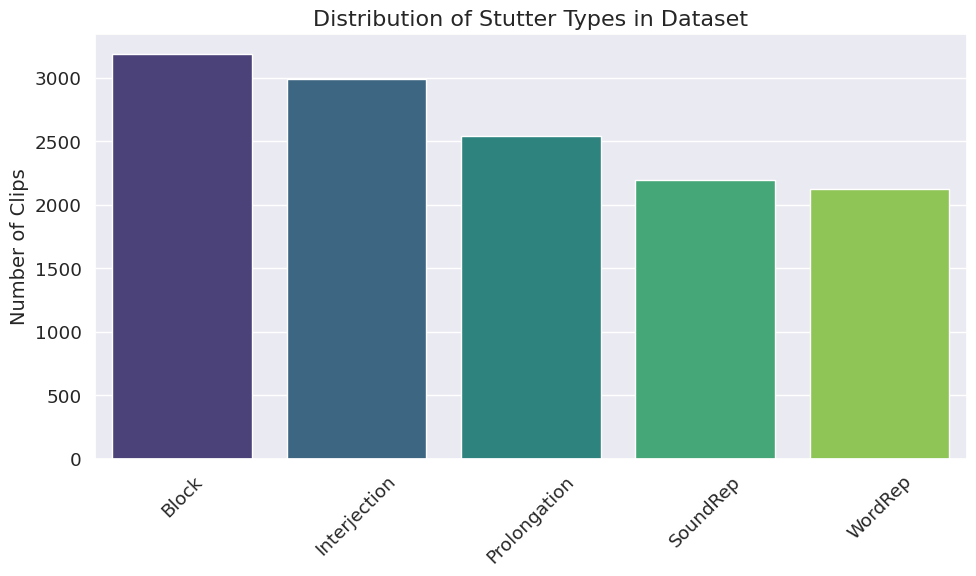

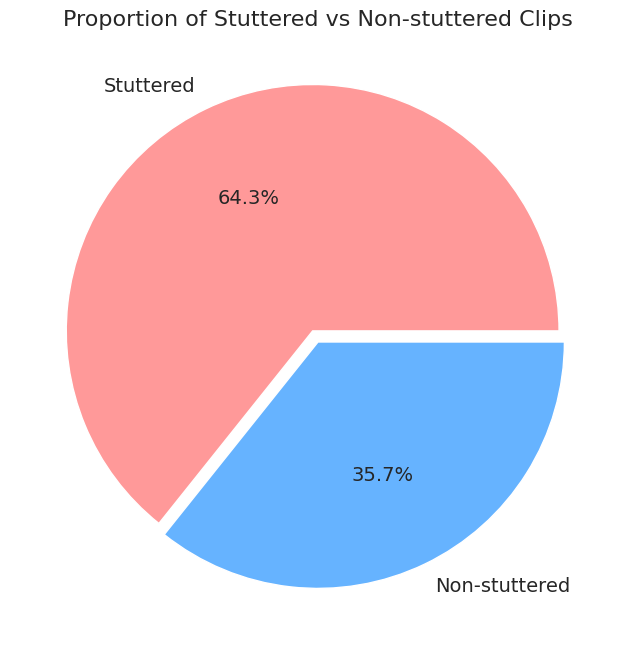

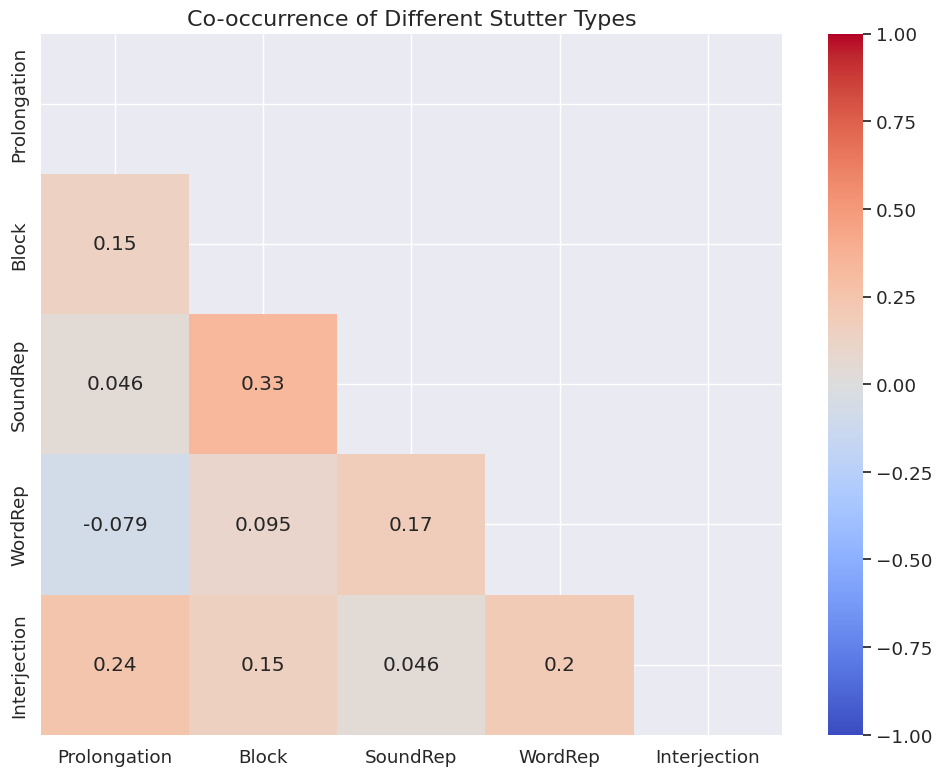

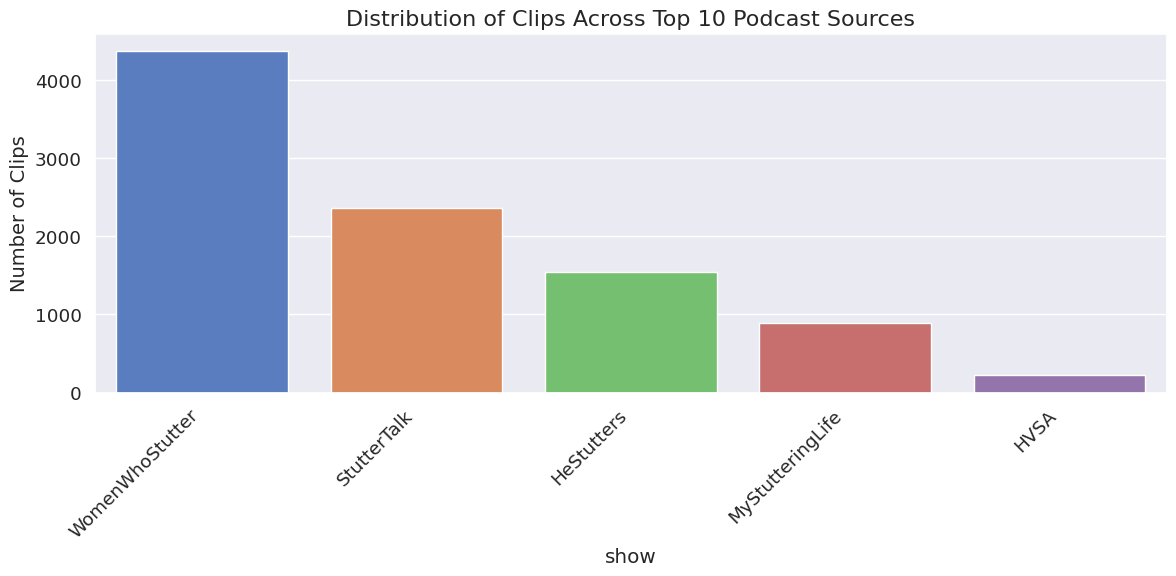

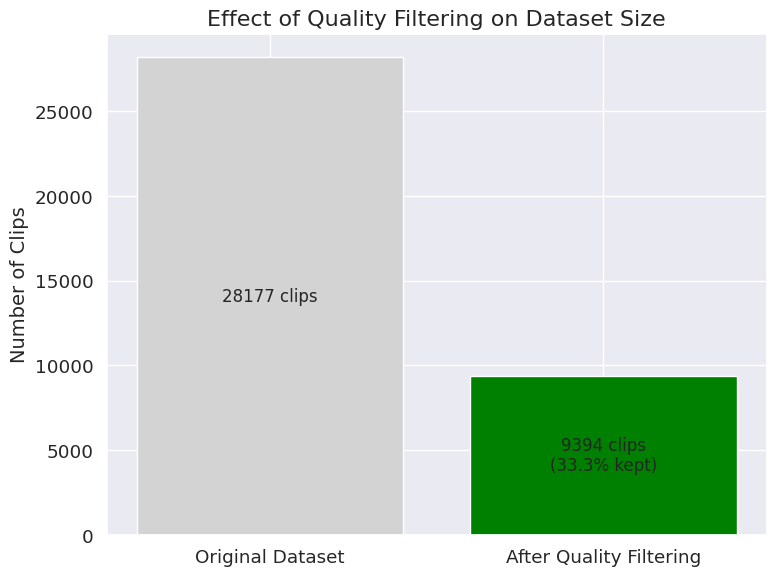

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 1. Distribution of stutter types
plt.figure(figsize=(10, 6))
stutter_counts = clips_df[STUTTER_TYPES].sum().sort_values(ascending=False)
ax = sns.barplot(x=stutter_counts.index, y=stutter_counts.values, palette='viridis')
plt.title('Distribution of Stutter Types in Dataset', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./plots/stutter_types_distribution.png', dpi=300)
plt.show()

# 2. Stutter vs Non-stutter proportion
plt.figure(figsize=(8, 8))
stutter_prop = [
    clips_df['Stutter Word'].sum(),
    clips_df['No Stutter Words'].sum()
]
plt.pie(stutter_prop,
        labels=['Stuttered', 'Non-stuttered'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        explode=(0.05, 0),
        textprops={'fontsize': 14})
plt.title('Proportion of Stuttered vs Non-stuttered Clips', fontsize=16)
plt.savefig('./plots/stutter_proportion.png', dpi=300)
plt.show()

# 3. Co-occurrence of stutter types (heatmap)
plt.figure(figsize=(10, 8))
stutter_corr = clips_df[STUTTER_TYPES].corr()
mask = np.triu(np.ones_like(stutter_corr, dtype=bool))
sns.heatmap(stutter_corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Co-occurrence of Different Stutter Types', fontsize=16)
plt.tight_layout()
plt.savefig('./plots/stutter_correlation.png', dpi=300)
plt.show()

# 4. Show distribution by podcast source
plt.figure(figsize=(12, 6))
source_counts = clips_df['show'].value_counts().head(10)
sns.barplot(x=source_counts.index, y=source_counts.values, palette='muted')
plt.title('Distribution of Clips Across Top 10 Podcast Sources', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./plots/source_distribution.png', dpi=300)
plt.show()

# 5. Quality filter effectiveness
original_count = len(labels_df)
filtered_count = len(clips_df)
removed_count = original_count - filtered_count

plt.figure(figsize=(8, 6))
plt.bar(['Original Dataset', 'After Quality Filtering'],
        [original_count, filtered_count],
        color=['lightgray', 'green'])
plt.text(0, original_count*0.5, f"{original_count} clips",
         ha='center', va='center', fontsize=12)
plt.text(1, filtered_count*0.5, f"{filtered_count} clips\n({filtered_count/original_count:.1%} kept)",
         ha='center', va='center', fontsize=12)
plt.title('Effect of Quality Filtering on Dataset Size', fontsize=16)
plt.ylabel('Number of Clips', fontsize=14)
plt.tight_layout()
plt.savefig('./plots/quality_filtering.png', dpi=300)
plt.show()


In [ ]:
import os
import gc
import warnings
import traceback
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Conv1D, GlobalAveragePooling1D, Input
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import IPython.display as ipd

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")


def extract_mfcc_features(audio_path, sr=16000, n_mfcc=13, visualize=False):
    """Enhanced MFCC feature extraction optimized for stutter detection"""
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        y = librosa.effects.preemphasis(y, coef=0.97)
        y = librosa.util.normalize(y)

        # MFCCs, deltas, delta2
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=int(0.025 * sr),
                                    hop_length=int(0.010 * sr), lifter=22)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Temporal + local stats
        temporal_fluct = np.std(np.diff(mfcc, axis=1), axis=1)
        local_var = np.mean(np.var(librosa.util.frame(mfcc, frame_length=5, hop_length=1), axis=1), axis=1)

        features = {
            "mfcc_mean": np.mean(mfcc, axis=1),
            "mfcc_std": np.std(mfcc, axis=1),
            "delta_mean": np.mean(delta, axis=1),
            "delta2_mean": np.mean(delta2, axis=1),
            "temporal_fluct": temporal_fluct,
            "local_var": local_var,
            "transition_rate": np.mean(np.abs(np.diff(mfcc, axis=1))),
            "mfcc_stability": np.mean(temporal_fluct),
            "raw_audio": y,
            "sr": sr,
        }

        if visualize:
            print("🎧 Playing audio...")
            ipd.display(ipd.Audio(y, rate=sr))
            plt.figure(figsize=(14, 10))
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title("Waveform")
            plt.subplot(3, 1, 2)
            librosa.display.specshow(mfcc, sr=sr, x_axis="time")
            plt.title("MFCCs")
            plt.colorbar()
            plt.subplot(3, 1, 3)
            plt.bar(range(n_mfcc), temporal_fluct)
            plt.title("Temporal Fluctuation per MFCC")
            plt.tight_layout()
            plt.show()

        return features

    except Exception as e:
        print(f"⚠️ Error extracting MFCC from {audio_path}: {str(e)}")
        return None


def extract_mfcc_vector(audio_path, n_mfcc=13):
    """Flattened MFCC vector for model input"""
    feats = extract_mfcc_features(audio_path, n_mfcc=n_mfcc)
    if feats is None:
        return None
    vec = np.concatenate([
        feats["mfcc_mean"], feats["mfcc_std"],
        feats["delta_mean"], feats["delta2_mean"],
        feats["temporal_fluct"], feats["local_var"],
        [feats["transition_rate"], feats["mfcc_stability"]]
    ])
    return vec


def batch_extract_features(clips_df, n_mfcc=13, batch_size=100):
    """Batch MFCC feature extraction"""
    all_feats, all_labels = [], []
    total_batches = len(clips_df) // batch_size + (len(clips_df) % batch_size > 0)

    for b in range(total_batches):
        batch = clips_df.iloc[b*batch_size:(b+1)*batch_size]
        print(f"\n🔹 Processing batch {b+1}/{total_batches}")
        for _, row in tqdm(batch.iterrows(), total=len(batch)):
            vec = extract_mfcc_vector(row["file_path"], n_mfcc=n_mfcc)
            if vec is not None:
                all_feats.append(vec)
                all_labels.append(row["Stutter Word"])
        gc.collect()

    if len(all_feats) == 0:
        raise RuntimeError("❌ No valid features extracted — check file paths.")

    return np.array(all_feats), np.array(all_labels)


def prepare_dataset(features, labels):
    """Split, scale, and prepare datasets"""
    X_train, X_temp, y_train, y_temp = train_test_split(
        features, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    dump(scaler, "mfcc_scaler.joblib")

    print(f"\n📊 Dataset split:")
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
    return X_train, X_val, X_test, y_train, y_val, y_test


In [13]:
!pip install -U "protobuf<4.25.0" --quiet
!pip install -U tensorflow==2.16.1 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 5.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.24.4 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 4.24.4 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.24.4 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 4.24.4 which is incompatible.
pydrive2 1.21.3 requires cryptograp

In [15]:
def build_cnn_model(input_shape):
    
    model = Sequential([
        Input(shape=(input_shape, 1)),
        Conv1D(64, 5, activation="relu", padding="same"),
        BatchNormalization(),
        Conv1D(128, 3, activation="relu", padding="same"),
        BatchNormalization(),
        GlobalAveragePooling1D(),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                           tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.summary()
    return model

In [16]:
# ======================================================
# 🚀 TRAINING & EVALUATION
# ======================================================

def train_model(model, X_train, y_train, X_val, y_val):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(class_weights)}

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    ]

    X_train_cnn = np.expand_dims(X_train, -1)
    X_val_cnn = np.expand_dims(X_val, -1)

    history = model.fit(X_train_cnn, y_train,
                        validation_data=(X_val_cnn, y_val),
                        epochs=50, batch_size=32,
                        callbacks=callbacks, class_weight=class_weights, verbose=1)
    return history


def evaluate_model(model, X_test, y_test):
    X_test_cnn = np.expand_dims(X_test, -1)
    results = model.evaluate(X_test_cnn, y_test, verbose=0)
    print(f"\n📈 Test Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, AUC: {results[2]:.4f}")
    y_pred = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.show()


def plot_history(history):
    """Plot training curves"""
    plt.figure(figsize=(12, 6))
    for metric in ["accuracy", "loss", "auc"]:
        plt.plot(history.history[metric], label=f"Train {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
        plt.title(metric.upper())
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()


🔹 Processing batch 1/94


100%|██████████| 100/100 [00:02<00:00, 47.03it/s]



🔹 Processing batch 2/94


100%|██████████| 100/100 [00:00<00:00, 162.94it/s]



🔹 Processing batch 3/94


100%|██████████| 100/100 [00:00<00:00, 163.55it/s]



🔹 Processing batch 4/94


100%|██████████| 100/100 [00:00<00:00, 165.65it/s]



🔹 Processing batch 5/94


100%|██████████| 100/100 [00:00<00:00, 163.14it/s]



🔹 Processing batch 6/94


100%|██████████| 100/100 [00:00<00:00, 161.64it/s]



🔹 Processing batch 7/94


100%|██████████| 100/100 [00:00<00:00, 153.62it/s]



🔹 Processing batch 8/94


100%|██████████| 100/100 [00:00<00:00, 165.05it/s]



🔹 Processing batch 9/94


100%|██████████| 100/100 [00:00<00:00, 159.77it/s]



🔹 Processing batch 10/94


100%|██████████| 100/100 [00:00<00:00, 162.83it/s]



🔹 Processing batch 11/94


100%|██████████| 100/100 [00:00<00:00, 165.17it/s]



🔹 Processing batch 12/94


100%|██████████| 100/100 [00:00<00:00, 165.74it/s]



🔹 Processing batch 13/94


100%|██████████| 100/100 [00:00<00:00, 161.29it/s]



🔹 Processing batch 14/94


100%|██████████| 100/100 [00:00<00:00, 160.57it/s]



🔹 Processing batch 15/94


100%|██████████| 100/100 [00:00<00:00, 161.93it/s]



🔹 Processing batch 16/94


100%|██████████| 100/100 [00:00<00:00, 162.92it/s]



🔹 Processing batch 17/94


100%|██████████| 100/100 [00:00<00:00, 166.46it/s]



🔹 Processing batch 18/94


100%|██████████| 100/100 [00:00<00:00, 155.95it/s]



🔹 Processing batch 19/94


100%|██████████| 100/100 [00:00<00:00, 162.93it/s]



🔹 Processing batch 20/94


100%|██████████| 100/100 [00:00<00:00, 165.71it/s]



🔹 Processing batch 21/94


100%|██████████| 100/100 [00:00<00:00, 156.74it/s]



🔹 Processing batch 22/94


100%|██████████| 100/100 [00:00<00:00, 166.07it/s]



🔹 Processing batch 23/94


100%|██████████| 100/100 [00:00<00:00, 163.18it/s]



🔹 Processing batch 24/94


100%|██████████| 100/100 [00:00<00:00, 166.75it/s]



🔹 Processing batch 25/94


100%|██████████| 100/100 [00:00<00:00, 163.01it/s]



🔹 Processing batch 26/94


100%|██████████| 100/100 [00:00<00:00, 167.98it/s]



🔹 Processing batch 27/94


100%|██████████| 100/100 [00:00<00:00, 160.15it/s]



🔹 Processing batch 28/94


100%|██████████| 100/100 [00:00<00:00, 165.67it/s]



🔹 Processing batch 29/94


100%|██████████| 100/100 [00:00<00:00, 155.10it/s]



🔹 Processing batch 30/94


100%|██████████| 100/100 [00:00<00:00, 165.03it/s]



🔹 Processing batch 31/94


100%|██████████| 100/100 [00:00<00:00, 166.21it/s]



🔹 Processing batch 32/94


100%|██████████| 100/100 [00:00<00:00, 163.41it/s]



🔹 Processing batch 33/94


100%|██████████| 100/100 [00:00<00:00, 164.35it/s]



🔹 Processing batch 34/94


100%|██████████| 100/100 [00:00<00:00, 166.37it/s]



🔹 Processing batch 35/94


100%|██████████| 100/100 [00:00<00:00, 168.17it/s]



🔹 Processing batch 36/94


100%|██████████| 100/100 [00:00<00:00, 166.86it/s]



🔹 Processing batch 37/94


100%|██████████| 100/100 [00:00<00:00, 166.52it/s]



🔹 Processing batch 38/94


100%|██████████| 100/100 [00:00<00:00, 161.22it/s]



🔹 Processing batch 39/94


100%|██████████| 100/100 [00:00<00:00, 164.87it/s]



🔹 Processing batch 40/94


100%|██████████| 100/100 [00:00<00:00, 154.14it/s]



🔹 Processing batch 41/94


100%|██████████| 100/100 [00:00<00:00, 167.15it/s]



🔹 Processing batch 42/94


100%|██████████| 100/100 [00:00<00:00, 168.20it/s]



🔹 Processing batch 43/94


100%|██████████| 100/100 [00:00<00:00, 167.84it/s]



🔹 Processing batch 44/94


100%|██████████| 100/100 [00:00<00:00, 167.91it/s]



🔹 Processing batch 45/94


100%|██████████| 100/100 [00:00<00:00, 166.15it/s]



🔹 Processing batch 46/94


100%|██████████| 100/100 [00:00<00:00, 164.40it/s]



🔹 Processing batch 47/94


100%|██████████| 100/100 [00:00<00:00, 164.52it/s]



🔹 Processing batch 48/94


100%|██████████| 100/100 [00:00<00:00, 167.40it/s]



🔹 Processing batch 49/94


100%|██████████| 100/100 [00:00<00:00, 166.70it/s]



🔹 Processing batch 50/94


100%|██████████| 100/100 [00:00<00:00, 166.91it/s]



🔹 Processing batch 51/94


100%|██████████| 100/100 [00:00<00:00, 158.24it/s]



🔹 Processing batch 52/94


100%|██████████| 100/100 [00:00<00:00, 159.45it/s]



🔹 Processing batch 53/94


100%|██████████| 100/100 [00:00<00:00, 162.76it/s]



🔹 Processing batch 54/94


100%|██████████| 100/100 [00:00<00:00, 162.41it/s]



🔹 Processing batch 55/94


100%|██████████| 100/100 [00:00<00:00, 160.15it/s]



🔹 Processing batch 56/94


100%|██████████| 100/100 [00:00<00:00, 166.54it/s]



🔹 Processing batch 57/94


100%|██████████| 100/100 [00:00<00:00, 167.39it/s]



🔹 Processing batch 58/94


100%|██████████| 100/100 [00:00<00:00, 164.20it/s]



🔹 Processing batch 59/94


100%|██████████| 100/100 [00:00<00:00, 162.65it/s]



🔹 Processing batch 60/94


100%|██████████| 100/100 [00:00<00:00, 161.68it/s]



🔹 Processing batch 61/94


100%|██████████| 100/100 [00:00<00:00, 161.97it/s]



🔹 Processing batch 62/94


100%|██████████| 100/100 [00:00<00:00, 157.60it/s]



🔹 Processing batch 63/94


100%|██████████| 100/100 [00:00<00:00, 166.10it/s]



🔹 Processing batch 64/94


100%|██████████| 100/100 [00:00<00:00, 162.72it/s]



🔹 Processing batch 65/94


100%|██████████| 100/100 [00:00<00:00, 164.97it/s]



🔹 Processing batch 66/94


100%|██████████| 100/100 [00:00<00:00, 163.90it/s]



🔹 Processing batch 67/94


100%|██████████| 100/100 [00:00<00:00, 164.79it/s]



🔹 Processing batch 68/94


100%|██████████| 100/100 [00:00<00:00, 159.11it/s]



🔹 Processing batch 69/94


100%|██████████| 100/100 [00:00<00:00, 163.72it/s]



🔹 Processing batch 70/94


100%|██████████| 100/100 [00:00<00:00, 163.00it/s]



🔹 Processing batch 71/94


100%|██████████| 100/100 [00:00<00:00, 163.14it/s]



🔹 Processing batch 72/94


100%|██████████| 100/100 [00:00<00:00, 166.90it/s]



🔹 Processing batch 73/94


100%|██████████| 100/100 [00:00<00:00, 152.94it/s]



🔹 Processing batch 74/94


100%|██████████| 100/100 [00:00<00:00, 164.38it/s]



🔹 Processing batch 75/94


100%|██████████| 100/100 [00:00<00:00, 163.66it/s]



🔹 Processing batch 76/94


100%|██████████| 100/100 [00:00<00:00, 161.28it/s]



🔹 Processing batch 77/94


100%|██████████| 100/100 [00:00<00:00, 166.05it/s]



🔹 Processing batch 78/94


100%|██████████| 100/100 [00:00<00:00, 159.23it/s]



🔹 Processing batch 79/94


100%|██████████| 100/100 [00:00<00:00, 168.46it/s]



🔹 Processing batch 80/94


100%|██████████| 100/100 [00:00<00:00, 165.81it/s]



🔹 Processing batch 81/94


100%|██████████| 100/100 [00:00<00:00, 147.25it/s]



🔹 Processing batch 82/94


100%|██████████| 100/100 [00:00<00:00, 152.15it/s]



🔹 Processing batch 83/94


100%|██████████| 100/100 [00:00<00:00, 168.03it/s]



🔹 Processing batch 84/94


100%|██████████| 100/100 [00:00<00:00, 159.79it/s]



🔹 Processing batch 85/94


100%|██████████| 100/100 [00:00<00:00, 164.19it/s]



🔹 Processing batch 86/94


100%|██████████| 100/100 [00:00<00:00, 164.84it/s]



🔹 Processing batch 87/94


100%|██████████| 100/100 [00:00<00:00, 166.66it/s]



🔹 Processing batch 88/94


100%|██████████| 100/100 [00:00<00:00, 161.99it/s]



🔹 Processing batch 89/94


100%|██████████| 100/100 [00:00<00:00, 154.30it/s]



🔹 Processing batch 90/94


100%|██████████| 100/100 [00:00<00:00, 160.82it/s]



🔹 Processing batch 91/94


100%|██████████| 100/100 [00:00<00:00, 160.60it/s]



🔹 Processing batch 92/94


100%|██████████| 100/100 [00:00<00:00, 164.02it/s]



🔹 Processing batch 93/94


100%|██████████| 100/100 [00:00<00:00, 161.56it/s]



🔹 Processing batch 94/94


100%|██████████| 94/94 [00:00<00:00, 165.43it/s]



📊 Dataset split:
Train: 6575, Val: 1409, Test: 1410


I0000 00:00:1762710078.038159      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 80, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 80, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,177 (133.50 KB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50


I0000 00:00:1762710081.905848     430 service.cc:148] XLA service 0x7b4058010350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762710081.906357     430 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762710082.338290     430 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/206 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5306 - auc: 0.5372 - loss: 0.7040 - precision: 0.6896 - recall: 0.5157

I0000 00:00:1762710085.290755     430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5437 - auc: 0.5713 - loss: 0.6954 - precision: 0.6992 - recall: 0.5154 - val_accuracy: 0.3648 - val_auc: 0.5833 - val_loss: 0.7334 - val_precision: 0.8235 - val_recall: 0.0155 - learning_rate: 0.0010
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5475 - auc: 0.5897 - loss: 0.6898 - precision: 0.6956 - recall: 0.5118 - val_accuracy: 0.5813 - val_auc: 0.6138 - val_loss: 0.6716 - val_precision: 0.7112 - val_recall: 0.5872 - learning_rate: 0.0010
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5729 - auc: 0.6111 - loss: 0.6779 - precision: 0.7071 - recall: 0.5639 - val_accuracy: 0.5628 - val_auc: 0.6109 - val_loss: 0.6809 - val_precision: 0.7273 - val_recall: 0.5121 - learning_rate: 0.0010
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5874 - auc: 0.6267 - loss: 0.6669 - precision: 0.7222 - recall: 0.5861 - val_accuracy: 0.5784 - val_auc: 0.6083 - val_loss: 0.6678 - val_precisio

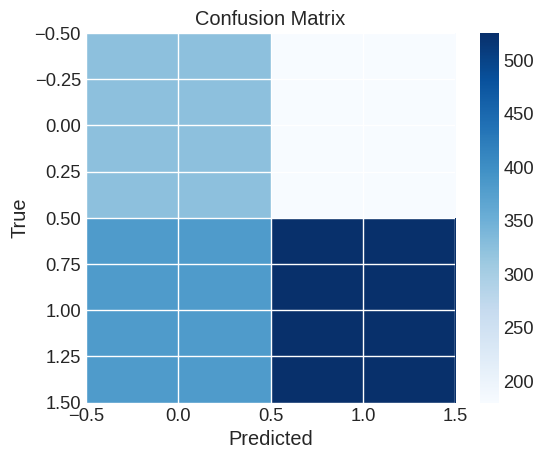

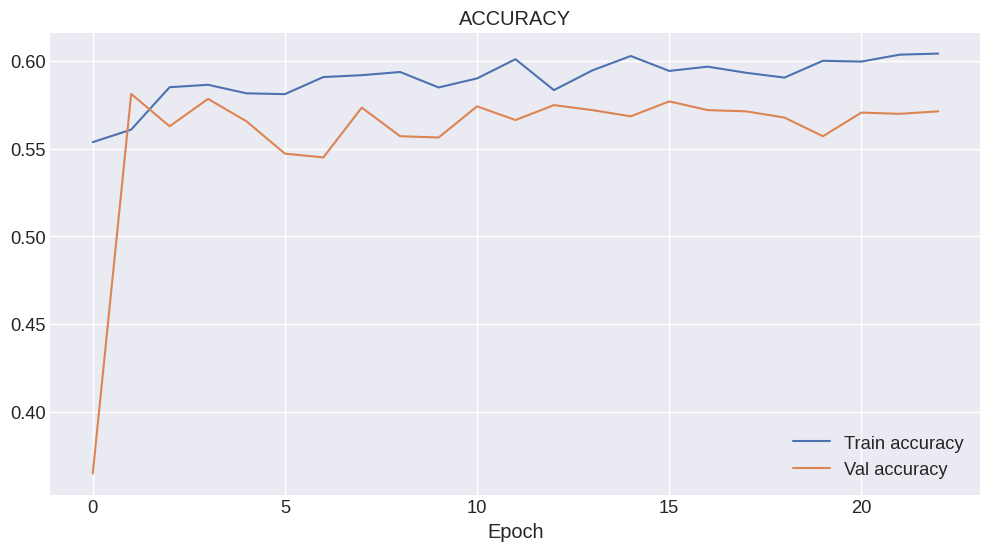

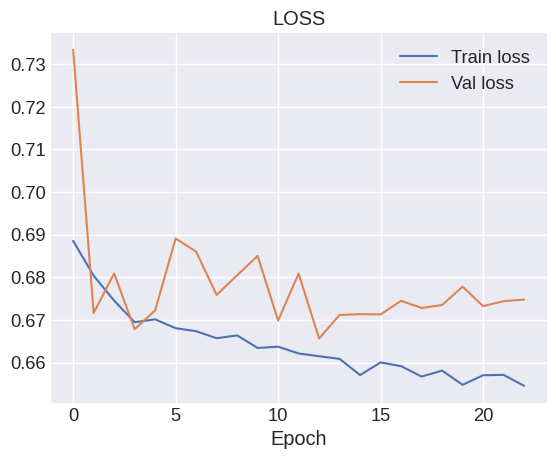

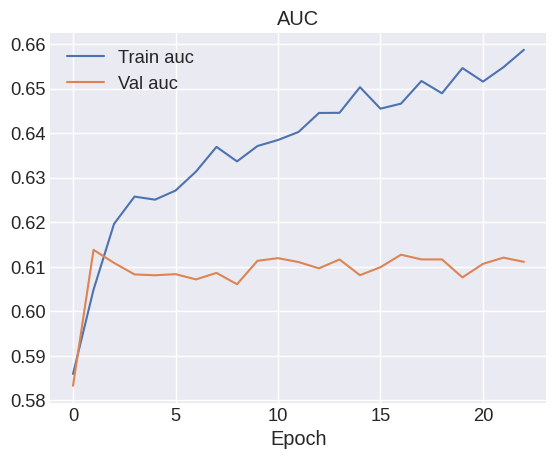

✅ Model saved successfully!


In [ ]:


def run_pipeline(clips_df, n_mfcc=13):
    if os.path.exists("mfcc_features.npy"):
        print("⚡ Loading cached features...")
        X = np.load("mfcc_features.npy")
        y = np.load("mfcc_labels.npy")
    else:
        X, y = batch_extract_features(clips_df, n_mfcc=n_mfcc)
        np.save("mfcc_features.npy", X)
        np.save("mfcc_labels.npy", y)

    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(X, y)
    model = build_cnn_model(X_train.shape[1])
    history = train_model(model, X_train, y_train, X_val, y_val)
    evaluate_model(model, X_test, y_test)
    plot_history(history)
    model.save("mfcc_cnn_stutter_model.h5")
    print("✅ Model saved successfully!")
    return model


def test_single_clip(clip_path, model, scaler, n_mfcc=13):
    """Predict stutter from a single clip"""
    f = extract_mfcc_features(clip_path, n_mfcc=n_mfcc, visualize=True)
    vec = np.concatenate([
        f["mfcc_mean"], f["mfcc_std"], f["delta_mean"], f["delta2_mean"],
        f["temporal_fluct"], f["local_var"], [f["transition_rate"], f["mfcc_stability"]]
    ])
    vec_scaled = scaler.transform(vec.reshape(1, -1))
    vec_scaled = np.expand_dims(vec_scaled, -1)
    prob = model.predict(vec_scaled)[0][0]
    pred = "🟢 Stutter" if prob > 0.5 else "🔵 No Stutter"
    print(f"\nPrediction: {pred} (Confidence: {prob:.3f})")


# ======================================================
# ▶️ EXECUTION LOGIC
# ======================================================
try:
    if os.path.exists("mfcc_cnn_stutter_model.h5") and os.path.exists("mfcc_scaler.joblib"):
        print("✅ Loading existing model and scaler...")
        model = load_model("mfcc_cnn_stutter_model.h5")
        scaler = load("mfcc_scaler.joblib")
        choice = input("Test a clip? (y/n): ")
        if choice.lower() == "y":
            clip_path = input("Enter path to .wav: ")
            test_single_clip(clip_path, model, scaler)
    else:
        model = run_pipeline(clips_df)
except Exception as e:
    print("❌ Pipeline failed:", e)
    traceback.print_exc()

In [ ]:


def run_pipeline(clips_df, n_mfcc=13):
    if os.path.exists("mfcc_features.npy"):
        print("⚡ Loading cached features...")
        X = np.load("mfcc_features.npy")
        y = np.load("mfcc_labels.npy")
    else:
        X, y = batch_extract_features(clips_df, n_mfcc=n_mfcc)
        np.save("mfcc_features.npy", X)
        np.save("mfcc_labels.npy", y)

    X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(X, y)
    model = build_cnn_model(X_train.shape[1])
    history = train_model(model, X_train, y_train, X_val, y_val)
    evaluate_model(model, X_test, y_test)
    plot_history(history)
    model.save("mfcc_cnn_stutter_model.h5")
    print("✅ Model saved successfully!")
    return model


def test_single_clip(clip_path, model, scaler, n_mfcc=13):
    """Predict stutter from a single clip"""
    f = extract_mfcc_features(clip_path, n_mfcc=n_mfcc, visualize=True)
    vec = np.concatenate([
        f["mfcc_mean"], f["mfcc_std"], f["delta_mean"], f["delta2_mean"],
        f["temporal_fluct"], f["local_var"], [f["transition_rate"], f["mfcc_stability"]]
    ])
    vec_scaled = scaler.transform(vec.reshape(1, -1))
    vec_scaled = np.expand_dims(vec_scaled, -1)
    prob = model.predict(vec_scaled)[0][0]
    pred = "🟢 Stutter" if prob > 0.5 else "🔵 No Stutter"
    print(f"\nPrediction: {pred} (Confidence: {prob:.3f})")

try:
    if os.path.exists("mfcc_cnn_stutter_model.h5") and os.path.exists("mfcc_scaler.joblib"):
        print("✅ Loading existing model and scaler...")
        model = load_model("mfcc_cnn_stutter_model.h5")
        scaler = load("mfcc_scaler.joblib")
        choice = input("Test a clip? (y/n): ")
        if choice.lower() == "y":
            clip_path = input("Enter path to .wav: ")
            test_single_clip(clip_path, model, scaler)
    else:
        model = run_pipeline(clips_df)
except Exception as e:
    print("❌ Pipeline failed:", e)
    traceback.print_exc()

In [66]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0. 1.]
Unique labels in y_test: [0. 1.]
